In [1]:
from src.utils.results_utils import *
import pandas as pd
from jellyfish import soundex
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Analysis of the differences in respect to theirs origins

In [2]:
# Read and present the data
df_ethnicity = pd.read_csv('data/name_ethnicity.csv')
df_ethnicity['Country'].value_counts()

Country
Slavic              3035
English-Speaking    2812
Germanic            2359
Romance             1847
Hispanic             891
Nordic               882
East Asian           673
Name: count, dtype: int64

In [3]:
total_count = len(df_ethnicity['Name'])
name_count = df_ethnicity['Name'].nunique()
country_count = df_ethnicity['Country'].nunique()

summary_df = pd.DataFrame({
    'Category': ['Total Names','Unique Names', 'Unique Regions'],
    'Count': [total_count, name_count, country_count]
})

summary_df.head()

,Category,Count
0,Total Names,12499
1,Unique Names,3951
2,Unique Regions,7


In [4]:
def get_vowel_stats(df: pd.DataFrame) -> tuple:
    vowels = set('aeiouy')

    # Count vowels in a name
    def count_vowels(name):
        return sum(1 for char in name.lower() if char in vowels)

    # Count consonants in a name (alphabetic characters excluding vowels)
    def count_consonants(name):
        return sum(1 for char in name.lower() if char.isalpha() and char not in vowels)

    # Add counts to the DataFrame
    df['vowel_count'] = df['Name'].apply(count_vowels)
    df['consonant_count'] = df['Name'].apply(count_consonants)
    df['name_length'] = df['vowel_count'] + df['consonant_count']

get_vowel_stats(df_ethnicity)

df_ethnicity.head()

,Name,Country,vowel_count,consonant_count,name_length
0,Vaclav,Slavic,2,4,6
1,Allan,Slavic,2,3,5
2,Kristine,Nordic,3,5,8
3,Matteo,Romance,3,3,6
4,Isao,East Asian,3,1,4


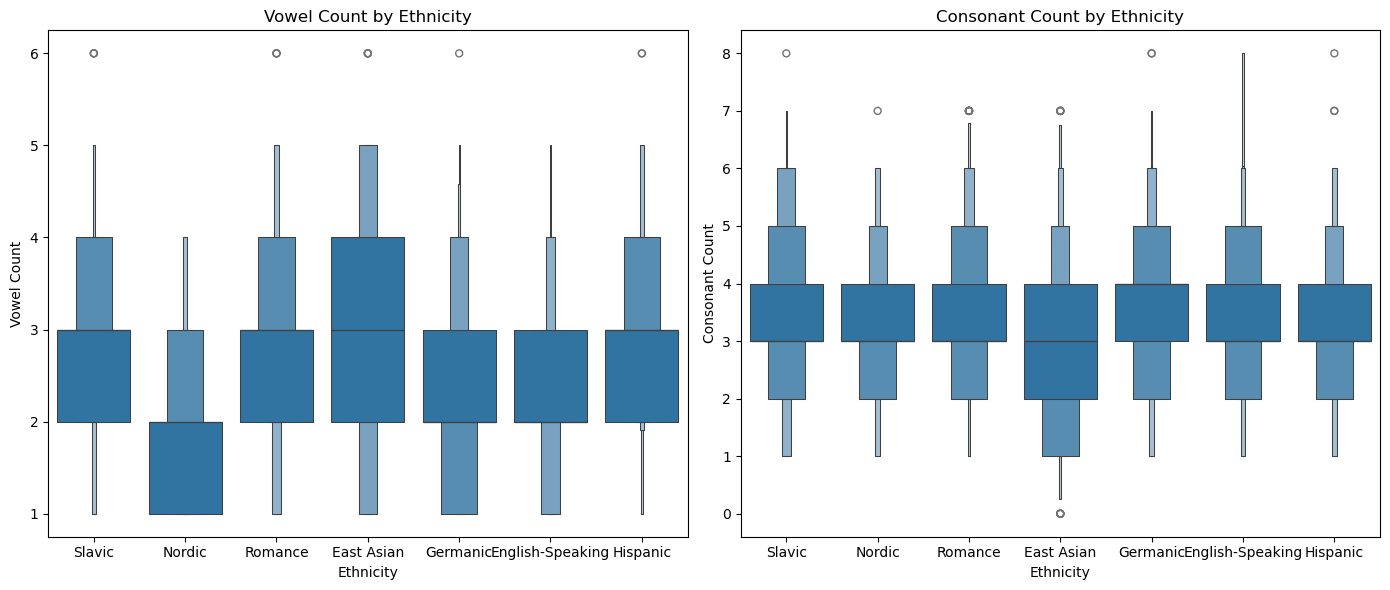

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot for vowel count by sex
sns.boxenplot(data=df_ethnicity, x='Country', y='vowel_count', ax=axes[0])
axes[0].set_title('Vowel Count by Ethnicity')
axes[0].set_xlabel('Ethnicity')
axes[0].set_ylabel('Vowel Count')

# Boxplot for consonant count by Country
sns.boxenplot(data=df_ethnicity, x='Country', y='consonant_count', ax=axes[1])
axes[1].set_title('Consonant Count by Ethnicity')
axes[1].set_xlabel('Ethnicity')
axes[1].set_ylabel('Consonant Count')

plt.tight_layout()

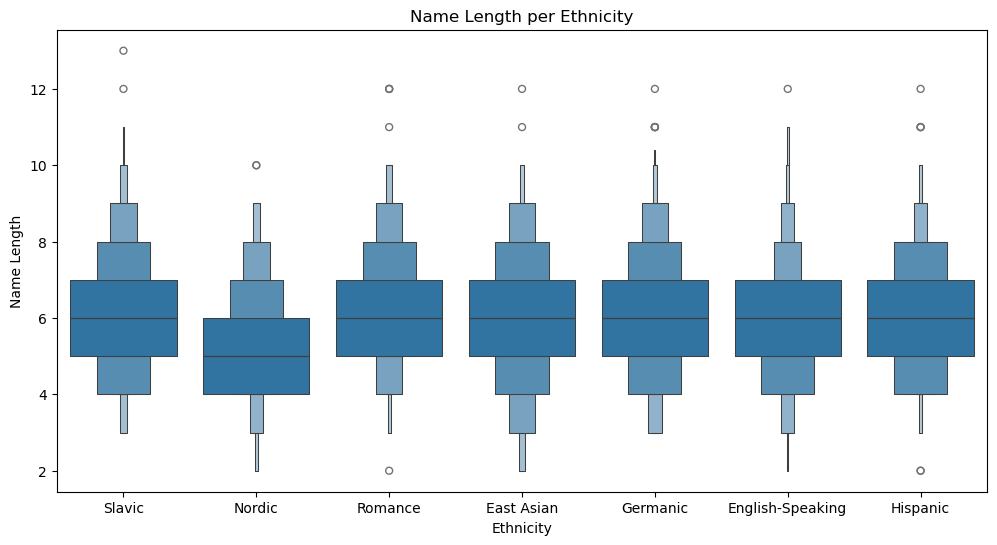

In [6]:
def create_boxenplot_by_Country(data: pd.DataFrame, column_name, abcisse):
    data['name_length'] = data[column_name].apply(lambda name: len(name))
    plt.figure(figsize=(12, 6))
    fig = sns.boxenplot(data, x=abcisse, y='name_length')
    fig.set_xlabel('Ethnicity')
    fig.set_ylabel('Name Length')
    fig.set_title('Name Length per Ethnicity')


create_boxenplot_by_Country(df_ethnicity, column_name='Name', abcisse='Country')

In [7]:
def create_letter_count_df(df, letter_position):

    df_letter = df.copy()
    df_letter['letter'] = df_letter['Name'].apply(lambda name: name[letter_position].lower())
    
    letter_counts_H = df_letter[df_letter['Country'] == 'Slavic']['letter'].value_counts()
    letter_counts_F = df_letter[df_letter['Country'] == 'English-Speaking']['letter'].value_counts()

    male_count = df_letter[df_letter['Country'] == 'Slavic'].shape[0]
    female_count = df_letter[df_letter['Country'] == 'English-Speaking'].shape[0]
    letter_counts_H_percentage = letter_counts_H / male_count*100
    letter_counts_F_percentage = letter_counts_F / female_count*100
    letter_counts = pd.concat([letter_counts_H_percentage, letter_counts_F_percentage], axis=1)
    letter_counts.columns = ['letter_men', 'letter_women']
    letter_counts = letter_counts.head(26)  # Limit to top 26 letters

    top_letter_names = (
        df_letter.groupby(['letter', 'Country'])['Name']
        .apply(lambda x: x.value_counts().head(3).index.tolist())
        .unstack(fill_value=[])
    )

    return letter_counts, top_letter_names

def plot_letter_name_percentage(df, letter_position, comparison):

    letter_counts, top_letter_names = create_letter_count_df(df, letter_position)

    if letter_position == 0:
        title = f'Percentage of Names Starting by Each Letter by {comparison}'
    else:
        title = f'Percentage of Names Ending by Each Letter by {comparison}'

    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=letter_counts.index,
        y=letter_counts['letter_men'],
        name='Slavic',
        marker_color='salmon',
        hovertext=[f"Top names: {', '.join(top_letter_names.loc[letter, 'Slavic'])}" if 'Slavic' in top_letter_names.columns else "" for letter in letter_counts.index],
        hoverinfo="text"
    ))

    fig.add_trace(go.Bar(
        x=letter_counts.index,
        y=letter_counts['letter_women'],
        name='English-Speaking',
        marker_color='skyblue',
        hovertext=[f"Top names: {', '.join(top_letter_names.loc[letter, 'English-Speaking'])}" if 'English-Speaking' in top_letter_names.columns else "" for letter in letter_counts.index],
        hoverinfo="text"
    ))

    fig.update_layout(
        title=title,
        xaxis_title='Letter of the Name',
        yaxis_title='% of Total Names by Origin',
        barmode='group',
        yaxis=dict(ticksuffix='%'),
        legend_title="Origin:"
    )

    fig.show()

plot_letter_name_percentage(df_ethnicity, 0, comparison='Country')
plot_letter_name_percentage(df_ethnicity, -1, comparison='Country')

In [8]:
df_ethn_stats = df_ethnicity.explode('Country')

contingency_table = create_contingency_table(df_ethn_stats,'Name','Country')
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"p-value: {p_value}")

Chi-Square Statistic: 58198.75
p-value: 0.0


The p-value is very close to zero, hence we can say that there is an association between character names and genres. We will now try to quantify this association using Cramér's V.

In [9]:

n = contingency_table.sum().sum()
k = min(contingency_table.shape)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))

print(f"Cramér's V: {cramers_v:.3f}")

Cramér's V: 0.881


The Cramér's V is superior to 0.80 meaning that there is a strong association between the country and the name.

# Creation of the model

In [10]:
def find_unusual_characters(df, column_name, allowed_chars='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'):
    """
    Identify all unique characters in a column that are not in the allowed characters.

    Parameters:
        df (pd.DataFrame): The dataset containing the column.
        column_name (str): The name of the column to analyze.
        allowed_chars (str): A string of allowed characters.

    Returns:
        set: A set of unique unusual characters.
    """
    # Create a set of allowed characters
    allowed_set = set(allowed_chars)
    
    # Combine all characters in the specified column
    all_characters = ''.join(df[column_name].dropna().astype(str))
    
    # Find unusual characters
    unusual_characters = set(all_characters) - allowed_set
    
    # Print and return the unusual characters
    print("Unusual Characters Found:", unusual_characters)

In [11]:
find_unusual_characters(df_ethnicity, 'Name')

Unusual Characters Found: {'è', 'ï', 'ü', 'Ã', 'é', '¶', 'ë', 'ç', 'á', 'ö', 'Ö', 'ä', '©'}


Encode the Coutries as numbers :

In [12]:
class ColumnEncoder:
    def __init__(self, column_name):
        """
        Initialize the encoder for a specific column.
        """
        self.column_name = column_name
        self.legend = None  # To store the legend of encoded values

    def fit_transform(self, df):
        """
        Encodes the column in the DataFrame as integers and stores the legend.
        """
        if self.column_name not in df.columns:
            raise ValueError(f"Column '{self.column_name}' not found in DataFrame.")
        
        # Factorize the column and store the legend
        df[self.column_name], self.legend = pd.factorize(df[self.column_name])
        return df

    def get_legend(self):
        """
        Generates a DataFrame containing the legend of encoded values.
        """
        if self.legend is None:
            raise ValueError("The encoder has not been fitted. Call `fit_transform` first.")
        
        legend_df = pd.DataFrame({
            'Encoded Value': range(len(self.legend)),
            self.column_name: self.legend
        })
        return legend_df

In [13]:
# Encode the column in the DataFrame
encoder = ColumnEncoder(column_name='Country')
df_ethnicity = encoder.fit_transform(df_ethnicity)

# Get the legend 
legend_df = encoder.get_legend()
print("Legend:")
legend_df.head(14)


Legend:


,Encoded Value,Country
0,0,Slavic
1,1,Nordic
2,2,Romance
3,3,East Asian
4,4,Germanic
5,5,English-Speaking
6,6,Hispanic


In [14]:
df_ethnicity.sample(5)

,Name,Country,vowel_count,consonant_count,name_length
94,Edwin,5,2,3,5
11779,Catherine,5,4,5,9
9744,Lisa,5,2,2,4
12283,Fritz,4,1,4,5
5471,Henri,2,2,3,5


## 1. Name Lenght, Vowel/Consonant Count and Ratio, Soundex and N-Gram

In [15]:
class EthnicityDataProcessor:
    def __init__(self, ngram_range = (2, 3)):
        """
        Initialize the processor with optional n-gram range for text vectorization.
        """
        self.ngram_range = ngram_range
        self.vectorizer = None

    @staticmethod
    def analyze_name(name):
        if not isinstance(name, str) or not name.strip():  # Handle empty or invalid names
            return pd.Series({
                'Length': 0,  
                'Vowel Count': 0,
                'Consonant Count': 0,
                'Vowel/Consonant Ratio': 0,
            })

        vowels = set('aeiouyüéèäöÃëçÖïá')
        consonants = set('bcdfghjklmnpqrstvwxzç')
        length = len(name)
        vowel_count = sum(1 for char in name.lower() if char in vowels)
        consonant_count = sum(1 for char in name.lower() if char in consonants)
        return pd.Series({
            'Length': length,
            'Vowel Count': vowel_count,
            'Consonant Count': consonant_count,
            'Vowel/Consonant Ratio': vowel_count / consonant_count if consonant_count > 0 else 0,
        })

    @staticmethod
    def first_last_letter(name):
        """
        Create columns for the first and last letter of the name for an extended alphabet.
        Each column corresponds to a letter of the alphabet plus additional diacritic letters.
    """
        # Define the extended alphabet
        alphabet = 'abcdefghijklmnopqrstuvwxyzüéèäöÃëçÖïáéäÔþçÁøõãæšáàÂùðìôêÖØÀûßýÉïåÓúśíłÅÞūžâÍÈëōîñüèóöÕò'

        # Initialize all columns to 0
        columns = {f"{letter}_f": 0 for letter in alphabet}
        columns.update({f"{letter}_l": 0 for letter in alphabet})

        # Validate the input name
        if not isinstance(name, str) or not name.strip():
            return pd.Series(columns)
    
        # Get the first and last letter
        name = name.strip().lower()
        first_letter = name[0] if name else None
        last_letter = name[-1] if name else None

        # Set 1 for the corresponding first and last letter columns
        if first_letter in alphabet:
            columns[f"{first_letter}_f"] = 1
        if last_letter in alphabet:
            columns[f"{last_letter}_l"] = 1

        return pd.Series(columns)
        

    @staticmethod
    def add_diacritic_columns(names, diacritics="üéèäöÃëçÖïáéäÔþçÁøõãæšáàÂùðìôêÖØÀûßýÉïåÓúśíłÅÞūžâÍÈëōîñüèóöÕò"):
        """
        Add binary columns for each diacritic in the names.
        """
        diacritic_set = set(diacritics)
        diacritic_columns = {
            f"{diacritic}": names.apply(lambda name: 1 if diacritic in name.lower() else 0)
            for diacritic in diacritic_set
        }
        diacritic_df = pd.DataFrame(diacritic_columns)
        # Drop columns where no diacritics are found
        diacritic_df = diacritic_df.loc[:, (diacritic_df.sum(axis=0) > 0)]
        return diacritic_df

    @staticmethod
    def add_soundex_encoding(names):
        """
        Add Soundex encoding to the names.
        """
        soundex_series = names.apply(soundex)
        return pd.get_dummies(soundex_series, prefix='Soundex')

    def add_ngram_features(self, names):
        """
        Add n-gram features for the names using character-based n-grams.
        """
        if self.ngram_range is not None:
            self.vectorizer = CountVectorizer(analyzer='char', ngram_range=self.ngram_range)
            ngram_features = self.vectorizer.fit_transform(names)
            return pd.DataFrame(ngram_features.toarray(), columns=self.vectorizer.get_feature_names_out())
        return pd.DataFrame()

    def process(self, df):
        """
        Process the input DataFrame to add all the features.
        """
        # Analyze names
        df = df.join(df['Name'].apply(self.analyze_name))

        # Add diacritic columns
        diacritic_df = self.add_diacritic_columns(df['Name'])
        df = df.join(diacritic_df)

        # Add Soundex encoding
        soundex_df = self.add_soundex_encoding(df['Name'])
        df = pd.concat([df, soundex_df], axis=1)

        # Add first and last letter columns for the extended alphabet
        letter_df = df['Name'].apply(self.first_last_letter)
        df = pd.concat([df, letter_df], axis=1)

        # Add n-gram features
        ngram_df = self.add_ngram_features(df['Name'])
        df = pd.concat([df, ngram_df], axis=1)

        return df

In [16]:
# Process df_ethnicity
processor = EthnicityDataProcessor(ngram_range=(2, 3))
df_ethnicity_processed = processor.process(df_ethnicity)

df_ethnicity_processed.head()

,Name,Country,vowel_count,consonant_count,name_length,Length,Vowel Count,Consonant Count,Vowel/Consonant Ratio,è,...,öt,öta,öte,öth,üd,üdi,ün,ünt,ür,ürg
0,Vaclav,0,2,4,6,6.0,2.0,4.0,0.500000,0,...,0,0,0,0,0,0,0,0,0,0
1,Allan,0,2,3,5,5.0,2.0,3.0,0.666667,0,...,0,0,0,0,0,0,0,0,0,0
2,Kristine,1,3,5,8,8.0,3.0,5.0,0.600000,0,...,0,0,0,0,0,0,0,0,0,0
3,Matteo,2,3,3,6,6.0,3.0,3.0,1.000000,0,...,0,0,0,0,0,0,0,0,0,0
4,Isao,3,3,1,4,4.0,3.0,1.0,3.000000,0,...,0,0,0,0,0,0,0,0,0,0


**Par rapport à Soundex :** Phonetic algorithm designed to index words (particularly names) based on their pronunciation rather than their spelling. This is especially useful when trying to find names that sound similar but are spelled differently.

## 2. Scaling features and PCA

In [17]:
class PCAProcessor:
    def __init__(self, n_components=100):
        """
        Initialize the PCAProcessor with a specified number of components.
        """
        self.n_components = n_components
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components)
        self.pca_features = None
        self.explained_variance_ratio_ = None

    def fit_transform(self, df, drop_columns=None):
        """
        Fit the PCA model and transform the input DataFrame.
        """
        # Drop specified columns if provided
        if drop_columns:
            df_features = df.drop(columns=drop_columns)
        else:
            df_features = df.copy()

        # Standardize the data
        features_scaled = self.scaler.fit_transform(df_features)

        # Apply PCA
        self.pca_features = self.pca.fit_transform(features_scaled)
        self.explained_variance_ratio_ = self.pca.explained_variance_ratio_

        # Create a DataFrame for the PCA-transformed data
        pca_columns = [f'PC{i+1}' for i in range(self.n_components)]
        return pd.DataFrame(self.pca_features, columns=pca_columns, index=df.index)

    def plot_explained_variance(self):
        """
        Plot the cumulative explained variance by PCA components.
        """
        if self.explained_variance_ratio_ is None:
            raise ValueError("PCA has not been fitted. Run `fit_transform` first.")
        
        plt.figure(figsize=(8, 5))
        plt.plot(self.pca.explained_variance_ratio_.cumsum())
        plt.title("Cumulative Explained Variance by PCA Components")
        plt.xlabel("Number of Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.grid()
        plt.show()

    def merge_with_original(self, original_df, pca_df, keep_columns):
        """
        Merge the PCA-transformed DataFrame with the original DataFrame.
        """
        # Retain only specified columns and merge with PCA DataFrame
        merged_df = pd.concat([original_df[keep_columns], pca_df], axis=1)
        return merged_df

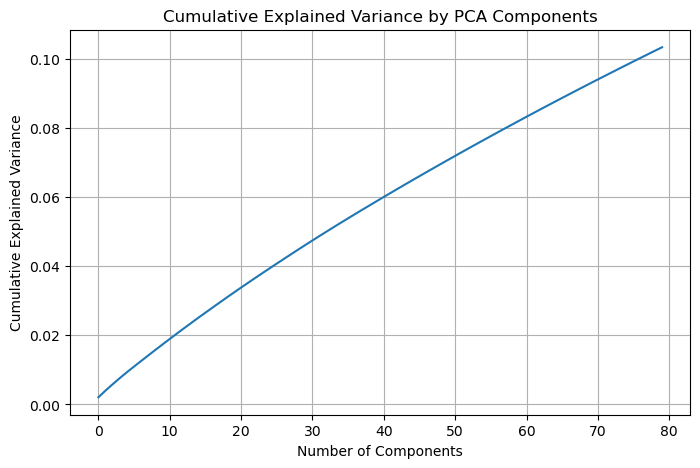

,Name,Country,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80
0,Vaclav,0,3.375457,5.933314,-0.800449,-0.142647,0.106128,-0.940419,1.260163,-2.876233,...,3.441870,5.262892,0.117860,0.276800,1.680026,-0.058108,-3.972486,-5.483624,-3.233124,-0.192921
1,Allan,0,0.072302,-0.662401,-1.221378,-0.108184,0.094427,-0.619220,0.222262,-0.818850,...,0.744281,0.852214,-0.402074,0.136730,0.101293,-0.894125,0.212701,0.702109,-0.423014,-0.436861
2,Kristine,1,4.832942,0.997434,11.448029,-0.291063,3.450899,-2.620453,-5.209369,1.330247,...,-2.336824,0.109955,-1.339495,-0.012012,1.101556,0.993812,-0.375707,-2.666031,-1.081179,1.156881
3,Matteo,2,-1.388654,0.087257,0.276795,-0.093901,1.343206,0.575072,-0.725777,0.457460,...,-4.729189,-1.069945,0.705029,-0.382351,-0.472382,0.212272,-0.637468,1.407488,-0.017055,1.338887
4,Isao,3,-2.459071,-0.431267,-1.578985,-0.041988,2.093049,-0.716848,-0.775903,-0.182706,...,1.852388,0.262499,-0.724565,0.652475,0.180927,0.859043,0.736041,-0.981006,-0.075532,0.741036


In [18]:
# Choice of number of PCA kept cmponents
n=80

# PCAProcessor
pca_processor = PCAProcessor(n_components=n)
pca_df = pca_processor.fit_transform(df_ethnicity_processed, drop_columns=['Name', 'Country']) # Fit PCA and transform the data
pca_processor.plot_explained_variance() # Plot explained variance
df_ethnicity_pca = pca_processor.merge_with_original(df_ethnicity_processed, pca_df, keep_columns=['Name', 'Country']) # Merge PCA components with original columns ('Name' and 'Country')

df_ethnicity_pca.head()

In [19]:
# Define features and targets
X = df_ethnicity_pca.drop(columns=['Name','Country'])
y = df_ethnicity_pca['Country']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"There are {X_train.shape[0]} samples in the training set.")
print(f"There are {X_test.shape[0]} samples in the testing set.")

There are 9999 samples in the training set.
There are 2500 samples in the testing set.


In [20]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# columns = ["Constant"] + list(df_ethnicity_pca.drop(columns=['Name','Country']).columns) 
# df_X_train = pd.DataFrame(X_train, columns=columns)

In [21]:
# Initialize the classifier
model = RandomForestClassifier(random_state=42)

# Train the classifier
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Detailed classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.7108
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       585
           1       0.82      0.37      0.51       177
           2       0.69      0.68      0.69       348
           3       0.91      0.83      0.87       151
           4       0.65      0.65      0.65       483
           5       0.65      0.80      0.71       579
           6       0.68      0.43      0.53       177

    accuracy                           0.71      2500
   macro avg       0.74      0.66      0.68      2500
weighted avg       0.72      0.71      0.70      2500



Ça run pas, dans l'idée c'est une cross validation pour tuner n (le nombre de principal componants qu'on va prendre)

In [22]:
# from sklearn.decomposition import PCA
# from sklearn.model_selection import cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# import matplotlib.pyplot as plt
# import numpy as np

# # List to store results
# results = []

# # Get the number of features in X (ensure it's not less than n_components)
# n_features = X.shape[1]

# # Iterate over the number of PCA components, from 50 to the number of features (n_features), in steps of 10
# for n in range(10, 100, 5):  # Ensure n <= n_features
#     # Apply PCA with n components
#     pca = PCA(n_components=n)
#     X_reduced = pca.fit_transform(X)

#     # Train and evaluate the model with cross-validation
#     model = RandomForestClassifier()
#     scores = cross_val_score(
#         model, X_reduced, y, cv=5, scoring='neg_mean_squared_error'
#     )
#     # Store the mean of absolute MSE scores
#     mean_mse = -np.mean(scores)
#     results.append((n, mean_mse))

# # Find the best number of components
# best_n, best_score = min(results, key=lambda x: x[1])  # Minimize error
# print(f"Best number of components: {best_n}, Lowest MSE: {best_score}")

# # Plot results
# plt.plot([r[0] for r in results], [r[1] for r in results])
# plt.xlabel('Number of Components')
# plt.ylabel('Mean Squared Error (MSE)')
# plt.title('Model Performance vs Number of Components')
# plt.show()

# 4 Predict ethnicities of the character dataset

In [23]:
df_character = pd.read_csv('data/cleaned.csv', usecols=['Character_name'])
find_unusual_characters(df_character, 'Character_name')

Unusual Characters Found: {'â', 'ú', 'ū', 'è', 'ü', 'ì', 'Þ', 'þ', 'ô', 'š', 'í', 'û', 'ß', 'å', 'Í', 'ç', 'á', 'ō', 'Ô', 'ð', 'ý', 'ž', 'æ', 'É', 'ï', 'Á', 'ù', 'ë', 'ñ', 'Ó', 'Ø', 'ê', 'ö', 'Ö', 'È', 'Â', 'õ', 'Å', 'ł', '-', 'î', 'ó', 'ø', 'é', 'À', 'à', 'Õ', 'ã', 'ä', 'ś', 'ò', 'с'}


In [24]:
df_names = pd.DataFrame(df_character[['Character_name']].rename(columns={'Character_name': 'Name'})).drop_duplicates()

df_names_1000 = df_names.head(10000).reset_index(drop=True)

In [25]:
# Process character_names
processor = EthnicityDataProcessor(ngram_range=(2, 3))
character_names_processed = processor.process(df_names_1000)

In [26]:
character_names_processed.sample(10)

,Name,Length,Vowel Count,Consonant Count,Vowel/Consonant Ratio,â,ú,ū,è,ü,...,ür,ürg,ürr,ürs,üt,ütt,üz,üzi,ūs,ūsa
5266,Busty,5.0,2.0,3.0,0.666667,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2632,Rosalinda,9.0,4.0,5.0,0.800000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
610,Linda,5.0,2.0,3.0,0.666667,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9093,Wade,4.0,2.0,2.0,1.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8031,Rajdharbhau,11.0,4.0,7.0,0.571429,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159,Manjit,6.0,2.0,4.0,0.500000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4980,Gonzales,8.0,3.0,5.0,0.600000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3302,Tia,3.0,2.0,1.0,2.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9520,Ari,3.0,2.0,1.0,2.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5627,Andra,5.0,2.0,3.0,0.666667,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
character_names_processed.isna().sum()  # Check for NaN values

Name                     0
Length                   0
Vowel Count              0
Consonant Count          0
Vowel/Consonant Ratio    0
                        ..
ütt                      0
üz                       0
üzi                      0
ūs                       0
ūsa                      0
Length: 8919, dtype: int64

In [28]:
print(character_names_processed[character_names_processed['Name'].isna()])  # Inspect rows with NaN in 'Name'

Empty DataFrame
Columns: [Name, Length, Vowel Count, Consonant Count, Vowel/Consonant Ratio, â, ú, ū, è, ü, ô, í, û, ß, å, ç, á, ý, æ, ï, ë, ñ, ö, ê, î, ó, ø, é, à, ã, ä, Soundex_A000, Soundex_A100, Soundex_A122, Soundex_A123, Soundex_A124, Soundex_A125, Soundex_A126, Soundex_A130, Soundex_A131, Soundex_A133, Soundex_A134, Soundex_A136, Soundex_A140, Soundex_A141, Soundex_A142, Soundex_A145, Soundex_A146, Soundex_A152, Soundex_A153, Soundex_A156, Soundex_A160, Soundex_A162, Soundex_A164, Soundex_A165, Soundex_A200, Soundex_A210, Soundex_A212, Soundex_A216, Soundex_A220, Soundex_A223, Soundex_A224, Soundex_A225, Soundex_A230, Soundex_A232, Soundex_A235, Soundex_A236, Soundex_A240, Soundex_A242, Soundex_A243, Soundex_A245, Soundex_A250, Soundex_A251, Soundex_A252, Soundex_A253, Soundex_A255, Soundex_A260, Soundex_A261, Soundex_A262, Soundex_A263, Soundex_A264, Soundex_A265, Soundex_A300, Soundex_A310, Soundex_A312, Soundex_A320, Soundex_A322, Soundex_A323, Soundex_A325, Soundex_A330, Sou

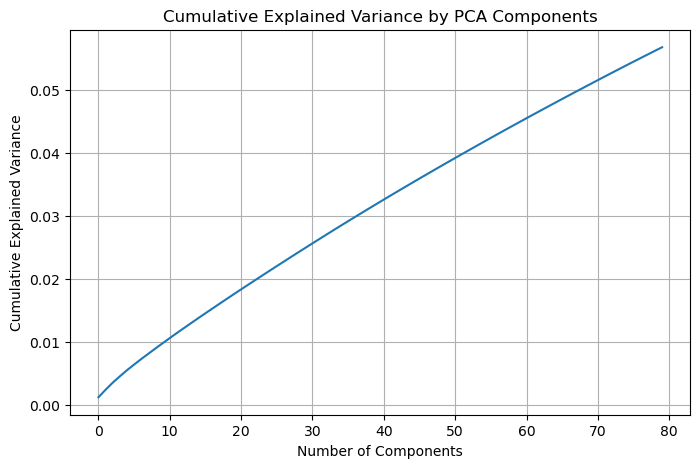

,Name,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80
0,Akooshay,-0.567194,0.187206,-0.356369,-0.266558,0.009756,-0.465318,-2.130915,2.722023,-1.110190,...,-0.480959,-1.944943,-1.325341,-0.219634,-0.713543,0.497254,-1.350825,-1.019163,-0.490050,1.503446
1,Melanie,-0.356841,0.084950,-0.500081,0.151834,-0.164802,-0.188571,-1.461496,-0.561091,0.386188,...,0.147304,-1.298767,0.287434,-0.276892,-0.110165,0.342084,1.129713,-1.031607,-0.098117,-0.617347
2,Williams,-0.273818,0.094751,-0.311389,-0.206904,-0.249199,-0.131653,0.195034,-1.068606,0.312294,...,2.326849,1.602386,-0.864185,-0.062153,-0.417385,0.251591,-1.514471,2.379940,1.831126,-1.048524
3,Jericho,0.153131,-0.115527,0.641447,-0.024547,-0.073700,0.021544,0.865642,-0.922663,0.088807,...,0.528531,0.711565,-0.382130,-0.777844,0.490499,2.240765,-0.160576,0.038307,1.093319,0.388859
4,Bashira,-0.350049,0.149310,-0.255362,-0.193049,-0.126521,-0.210176,-0.589755,2.692318,-1.477474,...,0.047712,-2.436061,-0.361543,-0.057574,0.238475,0.923741,-0.328523,-0.019762,0.057023,-0.709021


In [29]:
# PCA Processor
character_names_pca = pca_processor.fit_transform(character_names_processed, drop_columns=['Name']) # Fit PCA and transform the data
pca_processor.plot_explained_variance() # Plot explained variance
character_names_pca = pca_processor.merge_with_original(character_names_processed, character_names_pca, keep_columns=['Name']) # Merge PCA components with original columns 

character_names_pca.head()

In [30]:
scaler = StandardScaler()
character_names_pca = scaler.fit_transform(character_names_pca.drop(columns='Name'))
character_names_pca = sm.add_constant(character_names_pca)

df_names_1000['Country'] = model.predict(character_names_pca)

In [31]:
# Create a mapping dictionary from the legend DataFrame
country_mapping = dict(zip(legend_df['Encoded Value'], legend_df['Country']))

# Replace the numeric values in the 'Country' column with the corresponding names
df_names_1000['Country'] = df_names_1000['Country'].map(country_mapping)

In [32]:
df_names_1000.sample(5)

,Name,Country
5464,Arachchi,English-Speaking
8401,Papy,Slavic
9286,Fagerdal,English-Speaking
2608,Stacy,English-Speaking
5959,Gloansy,English-Speaking
